# Model Training

In [1]:
!pip install polars

In [2]:
import polars as pl
train_df_click = pl.read_parquet('../input/comp9417-preprocessing-and-test-data/train_df_click.parquet')
train_df_cart = pl.read_parquet('../input/comp9417-preprocessing-and-test-data/train_df_cart.parquet')
train_df_order = pl.read_parquet('../input/comp9417-preprocessing-and-test-data/train_df_order.parquet')

In [3]:
import pandas as pd

train_click = train_df_click.to_pandas()
train_cart = train_df_cart.to_pandas()
train_order = train_df_order.to_pandas()

In [4]:
import pickle

def save_model(name, model):
    f = f'/kaggle/working/{name}.pkl' 

    with open(f, 'wb') as file:  
        pickle.dump(model, file)

In [5]:
import xgboost as xgb
# from sklearn.model_selection import RandomizedSearchCV, GroupKFold

def train_XGB_k_fold(data, event_type, k):
    X_train = data.iloc[:,:-1]
    y_train = data.iloc[:, -1]
    
    groups_train = X_train.groupby('session').size().to_frame('size')['size'].to_numpy()
    dtrain = xgb.DMatrix(X_train, y_train, group=groups_train)

    params_list = [
        {'max_depth': 6, 'learning_rate' : 0.1},
        {'max_depth': 6, 'learning_rate' : 1},
        {'max_depth': 10, 'learning_rate' : 0.1},
        {'max_depth': 10, 'learning_rate' : 1}
    ]
    cv_list = []
    for params in params_list:
        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain, 
            seed=42,
            nfold=5,
            metrics='error'
        )
        cv_list.append(cv_results)
    return cv_list

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import xgboost as xgb 

# XGBoost
def train_XGB(data, event_type):
    X_train = data.iloc[:,:-1]
    y_train = data.iloc[:, -1]

    groups_train = X_train.groupby('session').size().to_frame('size')['size'].to_numpy()

    model = xgb.XGBRanker(  
        tree_method='hist',
        booster='gbtree',
        objective='rank:pairwise',
        random_state=42, 
        learning_rate=0.1,
        n_estimators=110
    )

    model.fit(
        X_train, 
        y_train, 
        group=groups_train,
        verbose=True
    )
    
    save_model(f'xgb_{event_type}', model)
    return model

In [7]:
train_list = [[train_click, 'click'], [train_cart, 'cart'], [train_order, 'order']]
models = []
for tr in train_list:
    models.append(train_XGB(tr[0], tr[1]))
    cv = train_XGB_k_fold(tr[0], tr[1], 5)

In [8]:
print(cv)

[   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.022938         0.000059         0.022945        0.000233
1          0.022939         0.000059         0.022940        0.000235
2          0.022939         0.000059         0.022943        0.000233
3          0.022939         0.000059         0.022940        0.000235
4          0.022939         0.000059         0.022942        0.000233
5          0.022939         0.000059         0.022940        0.000235
6          0.022939         0.000059         0.022940        0.000235
7          0.022939         0.000059         0.022940        0.000235
8          0.022939         0.000059         0.022940        0.000235
9          0.022939         0.000059         0.022939        0.000235,    train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.022938         0.000059         0.022945        0.000233
1          0.022938         0.000059         0.022945        0.000233
2          0.02293

In [9]:
for c in cv:
    print(c)

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.022938         0.000059         0.022945        0.000233
1          0.022939         0.000059         0.022940        0.000235
2          0.022939         0.000059         0.022943        0.000233
3          0.022939         0.000059         0.022940        0.000235
4          0.022939         0.000059         0.022942        0.000233
5          0.022939         0.000059         0.022940        0.000235
6          0.022939         0.000059         0.022940        0.000235
7          0.022939         0.000059         0.022940        0.000235
8          0.022939         0.000059         0.022940        0.000235
9          0.022939         0.000059         0.022939        0.000235
   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.022938         0.000059         0.022945        0.000233
1          0.022938         0.000059         0.022945        0.000233
2          0.022936 

In [10]:
for model in models:
    print(model.feature_importances_)

[0.04484385 0.23889495 0.03161987 0.03264527 0.02221127 0.14609377
 0.0200343  0.01712985 0.02904112 0.02513794 0.0222982  0.02908177
 0.02649697 0.02195423 0.01863313 0.20302597 0.03557755 0.03528002
 0.        ]
[0.0249705  0.06679607 0.01722644 0.02996965 0.06875387 0.06968132
 0.02040591 0.01457911 0.03646974 0.0312067  0.03862143 0.02421749
 0.2015196  0.08270505 0.02576416 0.16360733 0.0344306  0.0490751
 0.        ]
[0.01103456 0.03315636 0.00724761 0.01085564 0.04121509 0.03775735
 0.01741528 0.01194526 0.03771505 0.03112086 0.02354294 0.0109078
 0.2904749  0.2120239  0.02938654 0.10809088 0.06167137 0.02443862
 0.        ]


In [11]:
print(list(train_click.columns.values)[:-1])

['session', 'aid', 'last_type', 'session_length', 'events_ratio', 'clicks_ratio', 'carts_ratio', 'orders_ratio', 'interaction_count', 'click_count', 'buy_count', 'last_ts', 'click2cart', 'cart2buy', 'click2buy', 'last7days_interaction_rate', 'inclusion_rate', 'average_interactions_ph', 'count_within_session']


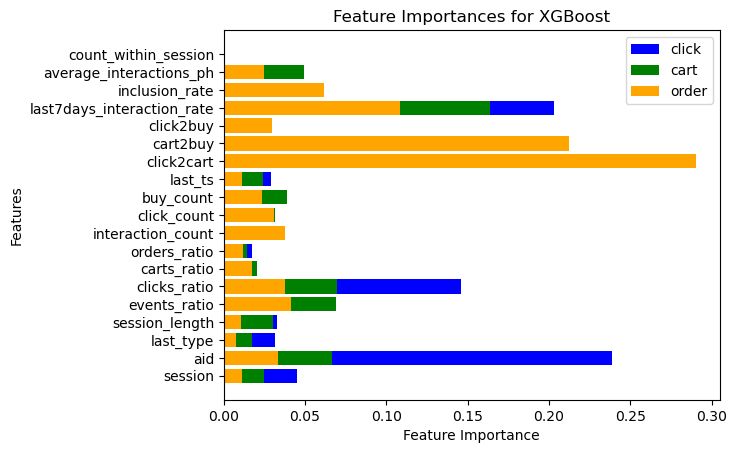

In [12]:
import matplotlib.pyplot as plt
feature_names = list(train_click.columns.values)[:-1]
fig, ax = plt.subplots()
colors = ['blue', 'green', 'orange']

for idx, model in enumerate(models):
    ax.barh(feature_names, model.feature_importances_, color=colors[idx], label=train_list[idx][1])

ax.legend()

ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
plt.title('Feature Importances for XGBoost')

# Show the plot
plt.show()

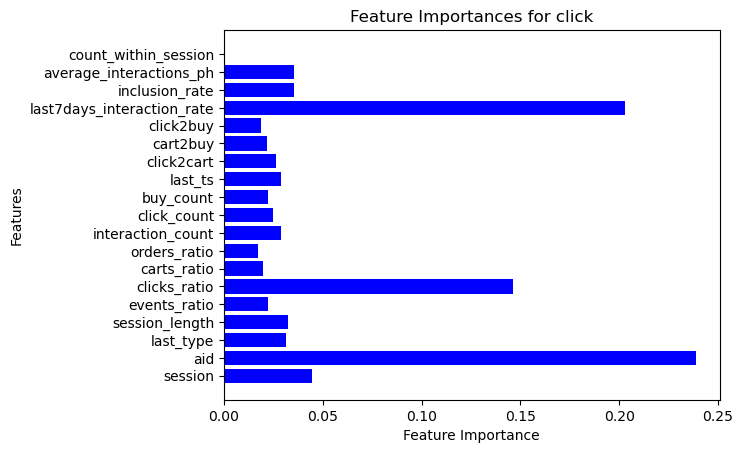

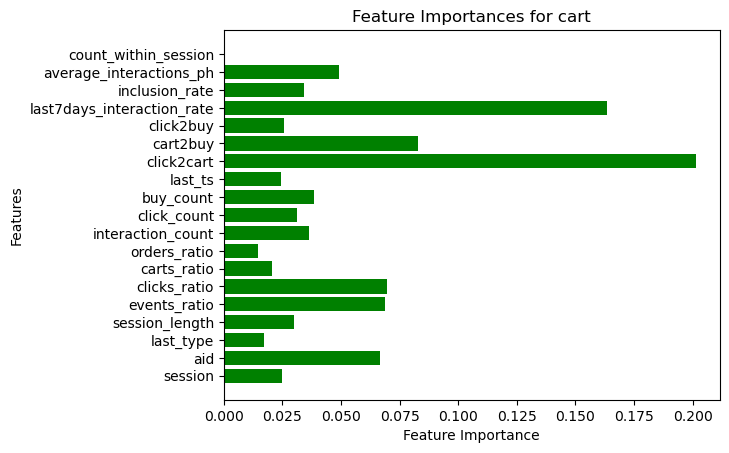

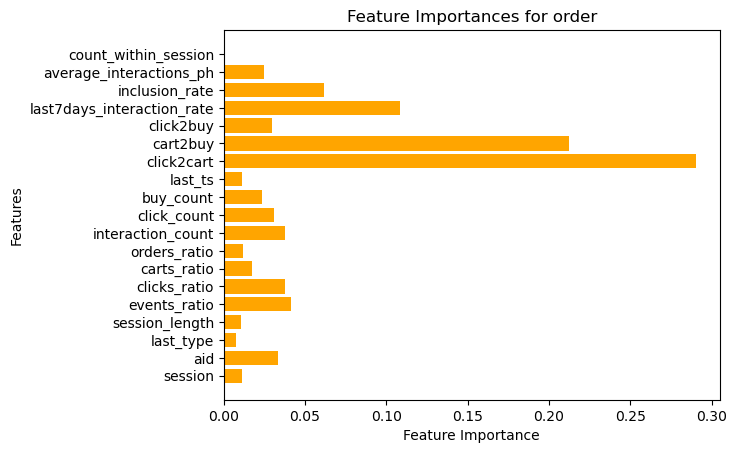

In [13]:
feature_names = list(train_click.columns.values)[:-1]
colors = ['blue', 'green', 'orange']

# Create separate plots for each model
for idx, model in enumerate(models):
    # Create a new figure and axis for each model's plot
    fig, ax = plt.subplots()

    # Plot feature importances for the current model
    ax.barh(feature_names, model.feature_importances_, color=colors[idx], label=train_list[idx][1])

    # Set axis labels and title for the current plot
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Features')
    plt.title(f'Feature Importances for {train_list[idx][1]}')

    # Show the plot
    plt.show()
